In [4]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [6]:
# Use tensorflow dataset to download the data
import tensorflow_datasets as tfds

In [7]:
# List all available datasets
datasets_list = tfds.list_builders() # All available datasets in tfds
print("food101" in datasets_list)

True


In [8]:
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [9]:
# Load in the data
(train_data, test_data), ds_info = tfds.load("food101",
                                             split=["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, # data returned as tuple (data, label)
                                             with_info = True )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteLJHJZJ/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteLJHJZJ/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [10]:
# features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [11]:
class_names = ds_info.features['label'].names

In [23]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [31]:
for image, label in train_one_sample:
  print(f"""
  image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  image shape: (382, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 52
  Class name (str form): gyoza
  


In [32]:
image

<tf.Tensor: shape=(382, 512, 3), dtype=uint8, numpy=
array([[[207, 220, 237],
        [207, 220, 237],
        [207, 220, 236],
        ...,
        [ 10,  11,  13],
        [ 11,  12,  14],
        [ 12,  13,  15]],

       [[208, 219, 237],
        [207, 220, 236],
        [208, 220, 236],
        ...,
        [  9,  10,  12],
        [ 10,  11,  13],
        [ 11,  12,  14]],

       [[216, 225, 242],
        [213, 225, 239],
        [214, 223, 238],
        ...,
        [ 11,  12,  14],
        [ 12,  13,  15],
        [ 12,  13,  15]],

       ...,

       [[ 33,  10,  16],
        [ 34,  11,  17],
        [ 33,  12,  17],
        ...,
        [ 10,   6,   5],
        [ 13,   7,   7],
        [ 15,   9,   9]],

       [[ 37,  12,  18],
        [ 36,  13,  19],
        [ 35,  15,  17],
        ...,
        [ 14,  10,   9],
        [ 19,  13,  13],
        [ 21,  15,  15]],

       [[ 39,  14,  20],
        [ 37,  14,  20],
        [ 36,  14,  17],
        ...,
        [ 19,  15,  1

In [33]:
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 381.5, -0.5)

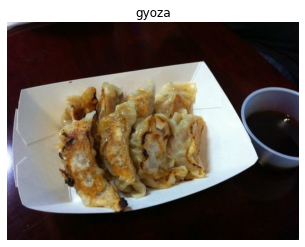

In [34]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Preprocessing functions

In [38]:
def preprocess_img(image, label, img_shape = 224):
  """
  Convert image datatype from 'uint8' to 'float32' and reshapes
  image to [img_shape, img_shape,colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [39]:
preprocessed_img = preprocess_img(image, label)[0]
print(f'Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype {image.dtype} \n')
print(f'Image after preprocessing:\n{preprocessed_img.shape},\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}')

Image before preprocessing:
 [[[207 220 237]
  [207 220 237]
  [207 220 236]
  ...
  [ 10  11  13]
  [ 11  12  14]
  [ 12  13  15]]

 [[208 219 237]
  [207 220 236]
  [208 220 236]
  ...
  [  9  10  12]
  [ 10  11  13]
  [ 11  12  14]]]..., 
Shape: (382, 512, 3), 
Datatype <dtype: 'uint8'> 

Image after preprocessing:
(224, 224, 3),
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


In [41]:
# Map preprocessing function to taining ( and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data and turn it into batches, then prefetch it for faster loading
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Same thing for test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [44]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)